# PRE-PROCESSING DBPEDIA DATA

In [1]:
import os
from pyspark.sql.functions import regexp_extract
from pyspark.sql.types import *
import pandas as pd
from pyspark.sql.functions import split
from pyspark import SparkContext
from pyspark.sql import SQLContext
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import pandas as pd
import geoplot
import boto3
import re
from io import StringIO

In [2]:
#sc = SparkContext("local", "First App")
sqlContext = SQLContext(sc)

In [3]:
#getting data from S3
s3 = boto3.resource('s3')
bucket = s3.Bucket('geo-clustering')
obj = bucket.Object(key='lat_longs.txt')
response = obj.get()
lines = response[u'Body'].read().split(b'\n')
raw_data=[]
for line in lines[1:]:
     raw_data.append(str(line, 'utf-8'))
x=raw_data.pop()
print(len(lines))

450151


In [4]:
#creating a pyspark data frame after extracting columns
raw_rdd = sc.parallelize(raw_data)
split_rdd=raw_rdd.map(lambda line: re.split(' +',line)).filter(lambda line: len(line)==3)
lat_long_raw_split=split_rdd.toDF()

In [5]:
#Removing longitudes and latitides with 0 magnitude
lat_long_no_zero_lat = lat_long_raw_split.filter(lat_long_raw_split._1 != 0)

In [6]:
#Selecting only required fields for this step
lat_long_raw_split=lat_long_raw_split.select("_1","_2")

In [7]:
#renaming columns
lat_long=lat_long_raw_split.select("_1","_2").withColumnRenamed("_1","latitude").withColumnRenamed("_2","longitude")

### VISULAIZATION USING GEOPANDAS

In [9]:
#Converting to pandas dataframe
lat_long_pd=lat_long.toPandas()
#Converting type of longitude and latitude to float from string to plot
lat_long_pd=lat_long_pd.astype({'latitude': 'float64'})
lat_long_pd=lat_long_pd.astype({'longitude': 'float64'})

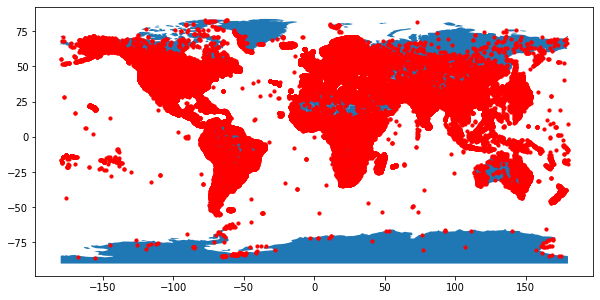

In [10]:
#plotting the graph
geometry = [Point(xy) for xy in zip(lat_long_pd['longitude'], lat_long_pd['latitude'])]
gdf = GeoDataFrame(lat_long_pd, geometry=geometry)   
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=10);

In [11]:
#Storing the pre-processed DBPedia data into S3
csv_buffer = StringIO()
lat_long_pd.to_csv(csv_buffer, sep="|", index=False)
s3.Object("geo-clustering", "lat_long_processed.csv").put(Body=csv_buffer.getvalue())

{'ResponseMetadata': {'RequestId': '217C4AE4BD1B0C49',
  'HostId': 'OK8a7l6q5aTWsNQg2NjlbrhLCGf6wYHNLuxBvteRycTrIgQ+2YtdtkkbKasLTYxyt5zlBKuyyfA=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'OK8a7l6q5aTWsNQg2NjlbrhLCGf6wYHNLuxBvteRycTrIgQ+2YtdtkkbKasLTYxyt5zlBKuyyfA=',
   'x-amz-request-id': '217C4AE4BD1B0C49',
   'date': 'Fri, 27 Nov 2020 01:52:54 GMT',
   'etag': '"6daa34eb4f3ba3e87edf763ebdffa542"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"6daa34eb4f3ba3e87edf763ebdffa542"'}